# ICDSS Challenges - PAIR TRADING
## Alessandro Serena (as6316@ic.ac.uk)

I decided to work on this challenge by focusing on 2 main aspects:
1. A systematic and efficient way to identify pairs of stocks with high correlation
2. The creation of a predictive model to predict the stock prices of a highly correlated pair based on their history

# PART 1 - Find candidate pairs of stocks

The objective of this section is to find a method to efficiently find pairs of stocks that can be used for pair trading.

## 1.a. Dimensionality reduction and data normalization
I decided to reduce the dimensionality of the dataset by applying a 5-days average kernel to each stock time series. The window of 5 days was chosen because the stock market stays open 5 days a week, so our new feature space will represent a weekly summary. 
Moreover, to make the different time series more comparable the weekly data is normalized to represent the percentage change w.r.t. the previous week instead of absolute values.

In [3]:
# IMPORT LIBRARIES
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


from reader import get_prices
from matplotlib import pyplot as plt
import pandas as pd
import math
from keras.losses import MAPE
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn.cluster import KMeans
import numpy as np
import pprint
from scipy.special import expit, logit

# fix random seed for reproducibility
np.random.seed(7)

pd.set_option('display.max_rows', 20)

In [4]:
# IMPORT AND CLEAN DATASET

prices = get_prices()
symbols = prices.columns

for stock in prices:
    nan_dirty = prices[stock].isnull().sum().sum()
    if nan_dirty > 2:
        prices = prices.drop(stock, axis=1)
    elif nan_dirty:
        prices[stock].fillna(prices[stock].mean())
symbols = prices.columns

In [5]:
# CLUSTER COMPANIES TOGETHER BASED ON STOCK TREND
# FEATURE VECTOR USED: 5-DAY PERCENTAGE CHANGE

weekly_priceDiff = {}

symbol_count = 0
for symbol in symbols:
    stock = prices[symbol]
    step = 5
    temp_ls = []

    for a in range(0,len(stock),step):
        stock_diff = 0
        opening_price = stock[a]
        closing_price = None
        try:
            closing_price = stock[a+step-1]
        except:
            closing_price = stock[a+step-2]
        stock_diff = (closing_price - opening_price)/opening_price*100
        temp_ls.append(stock_diff)
        
    weekly_priceDiff[symbol] = temp_ls
       

weekly_priceDiff = pd.DataFrame(weekly_priceDiff)
weekly_priceDiff = weekly_priceDiff.fillna(0)
weekly_priceDiff = weekly_priceDiff.transpose()

In [6]:
weekly_priceDiff.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
A,-1.597444,-1.265412,-4.383117,-0.546262,-1.016949,2.856171,0.718250,3.618316,2.558570,-0.713012,...,2.336449,1.778180,-0.164204,0.684015,0.235398,-2.281703,2.472814,-0.929102,-6.162346,2.354550
AAL,7.756813,9.126984,-7.446809,10.891089,-0.503356,6.832298,4.264706,7.112971,3.212851,-2.141058,...,6.464519,2.631579,-2.258065,-6.382364,-0.420521,-3.435195,3.607346,1.530719,1.442503,3.133212
AAP,0.643883,-2.311133,2.531646,-0.147965,-0.922554,2.549916,-6.203358,2.174988,1.084599,0.403513,...,-4.909274,-8.198112,1.648930,-1.302143,-0.292933,-0.709046,8.495382,-1.706223,12.042223,-0.830450
AAPL,-0.948554,-1.989434,-5.564081,-5.443333,-0.888390,3.675009,-2.710936,4.083606,6.539913,-0.173457,...,0.824033,0.450741,-0.643353,0.800461,3.103343,1.257971,-2.195781,2.417932,-1.889409,-0.159161
ABC,-2.177995,2.201974,-0.949945,1.129738,-5.604203,1.509573,0.579920,2.043743,-0.035714,1.105169,...,1.655589,0.397614,3.474320,-5.335897,-4.124116,0.267380,4.562334,4.725019,5.135298,0.943067


---
---
## 1.b Clustering

I have used the **k-means** clustering algorithm (with k = 200) in order to group together stocks that have similar weekly trends.

Since k-means does not assign the same number of datapoints to each centre, we obtain (as it can be seen below) some centers that have a single stock associated with them. This helps us in excluding those stocks from our search of highly correlated pairs.

In [7]:
# PERFORM K-MEANS CLUSTERING
clusters_no = 200

kmeans = KMeans(n_clusters=clusters_no, random_state=2).fit(weekly_priceDiff)

In [8]:
centers = np.zeros(clusters_no)
for i in range(clusters_no):
    centers[kmeans.labels_[i]] += 1

clusters = {}
for cluster in range(clusters_no):
    clusters[cluster] = symbols[np.where(kmeans.labels_==cluster)]
print("== SOME CLUSTERS AS EXAMPLE ==")
print("Cluster 0:", clusters[0].values)
print("Cluster 25:", clusters[25].values)
print("Cluster 60:", clusters[60].values)

== SOME CLUSTERS AS EXAMPLE ==
Cluster 0: ['HIG']
Cluster 25: ['ADM' 'AIZ' 'AJG' 'ALL' 'CB' 'CINF' 'CMCSA' 'GPC' 'GWW' 'HAS' 'IT' 'L'
 'MMC' 'PGR' 'RE' 'UPS' 'XL']
Cluster 60: ['DISCA' 'DISCK']


---
---
## 1.c Find highly correlated pairs

Now that we have the stocks grouped by clusters, I calculate the correlation coefficient of each pair of stocks belonging to the same cluster.
By ranking these coefficients we see that we find more than 1800 pairs with more than 30% (600+) of the pairs having a correlation coefficient of above 0.9.

In [9]:
# RANK CORRELATIONS IN SAME CLUSTER
corr_A = []
corr_B = []
corr_coeff = []
for c in clusters:
    symb = clusters[c]
    if len(symb) > 1:
        values = []
        for s in symb:
            values.append(prices[s].fillna(prices[s].mean()).to_list()) # TO CHECK! filling NaN with mean
        cluster_corr = np.corrcoef(values)
        for i in range(len(symb)):
            for j in range(i+1,len(symb)):
                corr_A.append(symb[i])
                corr_B.append(symb[j])
                corr_coeff.append(cluster_corr[i][j])
d = {}
d["stock_A"] = corr_A
d["stock_B"] = corr_B
d["corr"] = corr_coeff
correlations = pd.DataFrame(data=d)
correlations = correlations.sort_values(["corr"], ascending=[0])
correlations = correlations.reset_index()
correlations = correlations.drop("index", axis=1)

Candidate pairs found: 1822
 1.00 -  0.90 Correlation pairs	665	(36.5%)
 0.90 -  0.75 Correlation pairs	562	(30.85%)
 0.75 -  0.50 Correlation pairs	311	(17.07%)
 0.50 - -0.50 Correlation pairs	262	(14.38%)
-0.50 - -0.75 Correlation pairs	22	(1.21%)
-0.75 - -1.00 Correlation pairs	0	(0.0%)


     stock_A stock_B      corr
0        FOX    FOXA  0.997271
1      DISCA   DISCK  0.996414
2        LMT     RTN  0.993594
3        AWK     CMS  0.993416
4        DTE     NEE  0.992945
...      ...     ...       ...
1817     AEP      FE -0.656730
1818     DTE      FE -0.664058
1819      FE     SRE -0.680890
1820     DUK     EXC -0.689859
1821      FE     NEE -0.695324

[1822 rows x 3 columns]


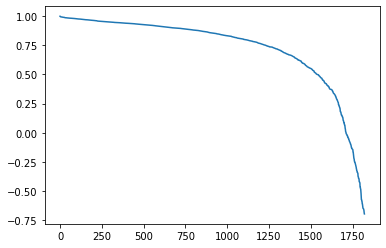

In [10]:
print(f"Candidate pairs found: {len(correlations)}")
plt.plot(correlations["corr"].to_list())

correlation_bins = (0,0,0,0,0)
bin0 = 0
bin1 = 0
bin2 = 0
bin3 = 0
bin4 = 0
bin5 = 0
for i in range(len(correlations)):
    corr = correlations.loc[i,"corr"]

    if corr >= 0.90:
        bin0+=1
    elif corr >= 0.75:
        bin1 += 1
    elif corr >= 0.50:
        bin2 += 1
    elif corr > -0.50:
        bin3 += 1
    elif corr > -0.75:
        bin4 += 1
    else:
        bin5 += 1
        
print(f" 1.00 -  0.90 Correlation pairs\t{bin0}\t({round(bin0/len(correlations)*100, 2)}%)")
print(f" 0.90 -  0.75 Correlation pairs\t{bin1}\t({round(bin1/len(correlations)*100, 2)}%)")
print(f" 0.75 -  0.50 Correlation pairs\t{bin2}\t({round(bin2/len(correlations)*100, 2)}%)")
print(f" 0.50 - -0.50 Correlation pairs\t{bin3}\t({round(bin3/len(correlations)*100, 2)}%)")
print(f"-0.50 - -0.75 Correlation pairs\t{bin4}\t({round(bin4/len(correlations)*100, 2)}%)")
print(f"-0.75 - -1.00 Correlation pairs\t{bin5}\t({round(bin5/len(correlations)*100, 2)}%)")


print('\n')
print(correlations)


stock_A         FOX
stock_B        FOXA
corr       0.997271
Name: 0, dtype: object

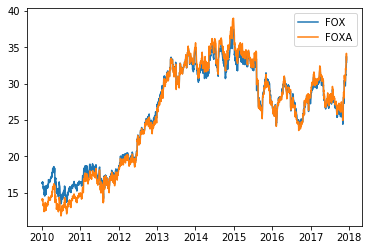

In [11]:
# PLOT MOST CORRELATED PAIR FOUND
best_corr = correlations.loc[0,:]
plt.plot(prices[best_corr.stock_A], label=best_corr.stock_A)
plt.plot(prices[best_corr.stock_B], label=best_corr.stock_B)
plt.legend()
best_corr

---
---
## 1.d Filtering candidate pairs found

Since we are interested in proceeding our trading analysis only on the best pairs found above, we proceed to filter the pairs by keeping only those with correlation above a set treshold (here set at 0.99). 

In [12]:
# Retain only stock pairs w/ correlation above treshold
CORR_TRESHOLD = 0.99
filtered_pairs = pd.DataFrame([pair for _,pair in correlations.iterrows() if pair['corr'] >= CORR_TRESHOLD])
print(f"Filtered {len(filtered_pairs)} stock pairs with correlation above {CORR_TRESHOLD}")

Filtered 15 stock pairs with correlation above 0.99


In [13]:
filtered_pairs

,stock_A,stock_B,corr
0,FOX,FOXA,0.997271
1,DISCA,DISCK,0.996414
2,LMT,RTN,0.993594
3,AWK,CMS,0.993416
4,DTE,NEE,0.992945
5,AET,CI,0.992136
6,LMT,NOC,0.991732
7,NOC,RTN,0.991140
8,CMS,EIX,0.990708
9,PNW,XEL,0.990634


---
---
# PART 2 - Generate a Predictive Model

The objective of this section is to creation and test a predictive model to predict the stock prices of the highly correlated pairs based on their history.

## 2.a Prepare the dataset for training

Before defining the predictive model, it is necessary to restructure the dataset for training.

The data used below is the original day-by-day data imported at the beginning (i.e. not the 5-days averaged data).

For each of the selected pairs, we take its time series and we reformat it into many smaller time series (each of them has 100 elements) in order to train the predictive model with smaller subsets of the original time series.

Each data point is regularized using the natural logarithm.

The shape of the full dataset is
- x-shape: (n_pairs=15, n_samples, look_back=100, n_features=2)
- y-shape: (n_pairs=15, n_samples, n_features=2)

This dataset is then split into training and test sets with a 80%/20% ratio.

In [14]:
# HELPER FUNCTION
# convert an array of values into a dataset matrix
look_back = 100
def xy_split_dataset(dataset, look_back=1, normalize=True):
    dataset = dataset.reshape(-1, 1)
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     if normalize:
#         dataset = scaler.fit_transform(dataset) 
    
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    X = np.array(dataX)
    Y = np.array(dataY)
    
    return X,Y


In [15]:
# PREPARE DATASET FOR TRAINING AND TESTING

# dataset x-shape: (n_pairs, n_samples, look_back, 2)
#         y-shape: (n_pairs, n_samples, 2)

n_pairs = len(filtered_pairs)
n_samples = len(prices.loc[:,best_corr.stock_B].to_numpy()) - look_back
n_timesteps = look_back
n_features = 2

def pandas_fill(arr):
    input_shape = arr.shape
    df = pd.DataFrame(arr)
    df.fillna(method='ffill', axis=0, inplace=True)
    out = df.to_numpy().reshape(input_shape)
    return out

print("Rearranging dataset...")
x_train = np.zeros(shape=(n_pairs, n_samples, look_back, 2), dtype=float)
y_train = np.zeros(shape=(n_pairs, n_samples, 2), dtype=float)
scalers = np.empty(shape=(n_pairs), dtype=MinMaxScaler)
pair_idx = 0
for _,pair in filtered_pairs.iterrows():
    print("Pair {} of {}".format(pair_idx+1, len(filtered_pairs)), end="\r")
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_A = prices.loc[:,pair.stock_A].to_numpy()
    stock_B = prices.loc[:,pair.stock_B].to_numpy()
    # Regularize data using Natural Logarithm
    stock_A = np.log(stock_A)
    stock_B = np.log(stock_B)
    # Clean NaN values
    stock_A = pandas_fill(stock_A)
    stock_B = pandas_fill(stock_B)
    
    x_stock_A, y_stock_A = xy_split_dataset(stock_A, look_back=look_back)
    x_stock_B, y_stock_B = xy_split_dataset(stock_B, look_back=look_back)
    
    for sample_idx in range(len(x_stock_A)):
        for ts_idx in range(len(x_stock_A[sample_idx])):
            x_train[pair_idx][sample_idx][ts_idx][0] = x_stock_A[sample_idx][ts_idx]
            x_train[pair_idx][sample_idx][ts_idx][1] = x_stock_B[sample_idx][ts_idx]
        y_train[pair_idx][sample_idx][0] = y_stock_A[sample_idx]
        y_train[pair_idx][sample_idx][1] = y_stock_B[sample_idx]
    
    pair_idx += 1

print("\nDONE")

Rearranging dataset...
Pair 15 of 15
DONE


In [16]:
print("Full X dataset", x_train.shape)
print("Full Y dataset", y_train.shape)
train_test_split_ratio = 0.8
trainX = x_train.reshape(n_pairs, n_samples, n_timesteps, n_features)
trainY = y_train.reshape(n_pairs, n_samples, n_features)

split_index = int(n_samples*train_test_split_ratio)
testX = trainX[:,split_index:]
trainX = trainX[:,:split_index]
testY = trainY[:,split_index:]
trainY = trainY[:,:split_index]

print("trainX ", trainX.shape)
print("trainY ", trainY.shape)
print("testX ", testX.shape)
print("testY ", testY.shape)

Full X dataset (15, 1899, 100, 2)
Full Y dataset (15, 1899, 2)
trainX  (15, 1519, 100, 2)
trainY  (15, 1519, 2)
testX  (15, 380, 100, 2)
testY  (15, 380, 2)


---
---
## 2.b The predictive models - LSTM

Now that the dataset is organized and split into training and test sets, we can proceed to define and train our predictive models.

Since the ultimate objective of this challenge is to research on pair trading, we want a model that would take as input a time series until a day `t` of both stocks in a highly correlated pair and it would give as output the price of the two stocks for the day `t+1`.

To do this, I used a LSTM network with only one layer. The loss function used is the **mean absolute percentage error (MAPE)** as it accounts for errors in predictions relatively to the magnitude of the correct value and not only for the absolute error as MSE would do.

Since we have multiple (15) candidate pairs, we train and test as many networks as the number of pairs.

In [19]:
# DEFINE AND TRAIN PREDICTIVE LSTM
n_pairs = trainX.shape[0]
models = np.empty(shape=(n_pairs), dtype=Sequential)
for pair_idx in range(n_pairs):
    print("Training model {} of {}".format(pair_idx+1, n_pairs), end="\r")
    model = Sequential()
    model.add(LSTM(150, input_shape=((trainX.shape[2], trainX.shape[3]))))
    model.add(Dense(2))
    model.compile(loss=MAPE, optimizer='adam')
    model.fit(trainX[pair_idx], trainY[pair_idx], epochs=5, batch_size=10, verbose=0)
    models[pair_idx] = model
print("\nDONE")

Training model 15 of 15
DONE


In [20]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [21]:
# TEST MODELS ON RESPECTIVE TEST SETS

test_results = np.zeros(shape=(n_pairs, 3), dtype=float)

for pair_idx in range(n_pairs):
    print("Testing model {} of {}".format(pair_idx+1, n_pairs), end="\r")
    predicted = np.exp(models[pair_idx].predict(testX[pair_idx]))
    true = np.exp(testY[pair_idx,:,:])
    
    stock_A_MAPE = mean_absolute_percentage_error(true[:,0], predicted[:,0])
    stock_B_MAPE = mean_absolute_percentage_error(true[:,1], predicted[:,1])
    combined_MAPE = (stock_A_MAPE + stock_B_MAPE)/2
    
    test_results[pair_idx] = [stock_A_MAPE, stock_B_MAPE, combined_MAPE]
print("\nDONE")

Testing model 15 of 15
DONE


---
---
## 2.c Results

After training and testing the LSTMs we can find the best model by looking for the one with the lowest combined MAPE value for its stocks.
The MAPE values of best one are shown below, together with the plots of the model predictions vs the real stock values.

In [22]:
print("MAPE values --> (1) Stock A    (2) Stock B    (3) Combined")
print(np.around(test_results, 4))

MAPE values --> (1) Stock A    (2) Stock B    (3) Combined
[[ 5.2758 10.1654  7.7206]
 [ 6.5566  3.2367  4.8966]
 [ 3.5174  9.5237  6.5205]
 [ 3.6167  2.7225  3.1696]
 [11.0043 10.337  10.6706]
 [14.8602  4.2608  9.5605]
 [ 9.0125  6.028   7.5202]
 [13.5321 19.1171 16.3246]
 [ 9.2676 10.6082  9.9379]
 [ 2.4568  2.1287  2.2927]
 [ 3.5875 12.487   8.0373]
 [ 3.2619  3.4874  3.3747]
 [ 4.2008  4.2548  4.2278]
 [ 1.3792  3.8781  2.6287]
 [ 2.1991  3.158   2.6786]]


In [23]:
# FIND MODEL WITH BEST COMBINED MAPE SCORE
best_pair_idx = np.argmin(np.array([x for _,_,x in test_results]))

stock_A_name = filtered_pairs.loc[best_pair_idx].stock_A
stock_B_name = filtered_pairs.loc[best_pair_idx].stock_B
print("--- BEST MODEL ---")
print("Combined MAPE:\t", round(test_results[best_pair_idx,2],4), "%")
print(stock_A_name,"MAPE:\t", round(test_results[best_pair_idx,0],4), "%")
print(stock_B_name,"MAPE:\t", round(test_results[best_pair_idx,1],4), "%")

--- BEST MODEL ---
Combined MAPE:	 2.2927 %
PNW MAPE:	 2.4568 %
XEL MAPE:	 2.1287 %


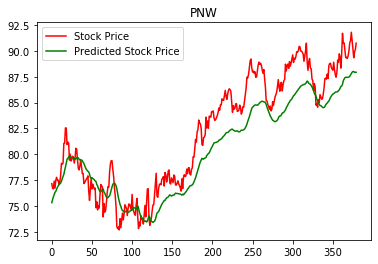

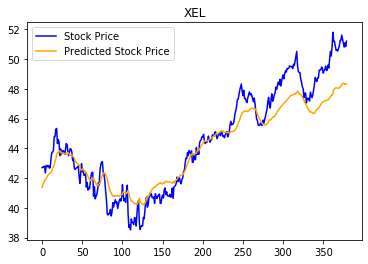

In [25]:
# PLOT PREDICTION vs. TRUE OF THE BEST PERFORMING PAIR MODEL
predicted = np.exp(models[best_pair_idx].predict(testX[best_pair_idx]))
true = np.exp(testY[best_pair_idx,:,:])
plt.figure(0)
plt.title(stock_A_name)
plt.plot(true[:,0], color = 'red', label = 'Stock Price')
plt.plot(predicted[:,0], color = 'green', label = 'Predicted Stock Price')
plt.legend()

plt.figure(1)
plt.title(stock_B_name)
plt.plot(true[:,1], color = 'blue', label = 'Stock Price')
plt.plot(predicted[:,1], color = 'orange', label = 'Predicted Stock Price')
plt.legend()

# Conclusion and Future Work

As the results above confirm, the methodology described in this notebook, for finding pairs and generating a predictive model in order to do pair trading, works.

Certainly if more time and computational power was available it would be intersting to do a rigourous tuning of the hyper-parameters of the system (e.g. no. of clusters, look_back value of the LSTM time series, number and size of the model layers, etc.).

Moreover, it would be interesting to setup a trading strategy based on this procedure and see how it would perform on real stock market data being generated every day.